In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import dimod

In [3]:
class QuantumClustering:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
    
    def build_qubo_matrix(self, embeddings, medoid_indices, qubo_matrix_path):
        """Constructs and saves the QUBO matrix for k-medoids clustering using cosine similarity."""
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        cosine_matrix = (embeddings @ embeddings.T) / (norms @ norms.T)
        np.fill_diagonal(cosine_matrix, 0)

        mapped_indices = np.arange(len(medoid_indices))

        for idx in mapped_indices:
            cosine_matrix[idx, idx] += 2  

        np.save(qubo_matrix_path, cosine_matrix)
        print(f"QUBO matrix saved at: {qubo_matrix_path}")
    
    def solve_qubo(self, qubo_matrix_path):
        """Loads and solves the QUBO problem using Simulated Annealing."""
        qubo_matrix = np.load(qubo_matrix_path)
        sampler = dimod.SimulatedAnnealingSampler()
        bqm = dimod.BinaryQuadraticModel.from_qubo(qubo_matrix)
        response = sampler.sample(bqm, num_reads=100)
        
        best_sample = response.first.sample
        assignments = np.array(sorted(best_sample.keys(), key=lambda x: best_sample[x], reverse=True)[:self.n_clusters])
        return assignments
    
    def save_results(self, cluster_assignments, save_path):
        """Saves optimized cluster assignments."""
        np.save(save_path, cluster_assignments)
        print(f"Final quantum cluster assignments saved at: {save_path}")

In [4]:
script_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(script_dir, "..", "..", "..", "data", "test_data"))
os.makedirs(data_dir, exist_ok=True)

In [5]:
np.random.seed(42)
doc_embeddings = np.random.rand(100, 5)
medoid_indices = np.random.choice(range(len(doc_embeddings)), size=5, replace=False)

In [6]:
qubo_matrix_path = os.path.join(data_dir, "test_qubo_matrix.npy")
quantum_clustering = QuantumClustering(n_clusters=len(medoid_indices))
quantum_clustering.build_qubo_matrix(doc_embeddings, medoid_indices, qubo_matrix_path)

QUBO matrix saved at: c:\Users\karishma\OneDrive\Projects\qCLEF\data\test_data\test_qubo_matrix.npy


In [7]:
clustered_output_path = os.path.join(data_dir, "test_quantum_cluster_labels.npy")
medoid_cluster_labels = quantum_clustering.solve_qubo(qubo_matrix_path)
quantum_clustering.save_results(medoid_cluster_labels, clustered_output_path)

Final quantum cluster assignments saved at: c:\Users\karishma\OneDrive\Projects\qCLEF\data\test_data\test_quantum_cluster_labels.npy


In [8]:
def assign_points_to_clusters(doc_embeddings, medoid_embeddings, medoid_cluster_labels):
    """Assigns each non-medoid point to the closest medoid using Euclidean distance."""
    distances = euclidean_distances(doc_embeddings, medoid_embeddings)
    closest_medoid = np.argmin(distances, axis=1)
    all_labels = medoid_cluster_labels[closest_medoid]
    return all_labels

In [9]:
medoid_embeddings = doc_embeddings[medoid_indices]
all_cluster_labels = assign_points_to_clusters(doc_embeddings, medoid_embeddings, medoid_cluster_labels)

In [10]:
final_clustered_output_path = os.path.join(data_dir, "final_test_quantum_clusters.npy")
np.save(final_clustered_output_path, all_cluster_labels)
print(f"Final reassigned cluster labels saved at: {final_clustered_output_path}")

Final reassigned cluster labels saved at: c:\Users\karishma\OneDrive\Projects\qCLEF\data\test_data\final_test_quantum_clusters.npy


In [14]:
unique_labels = np.unique(all_cluster_labels)
print(f"Unique Quantum Cluster Labels: {unique_labels}")
print(f"Number of Unique Clusters: {len(unique_labels)}")

Unique Quantum Cluster Labels: [ 0  1  2  3 44]
Number of Unique Clusters: 5


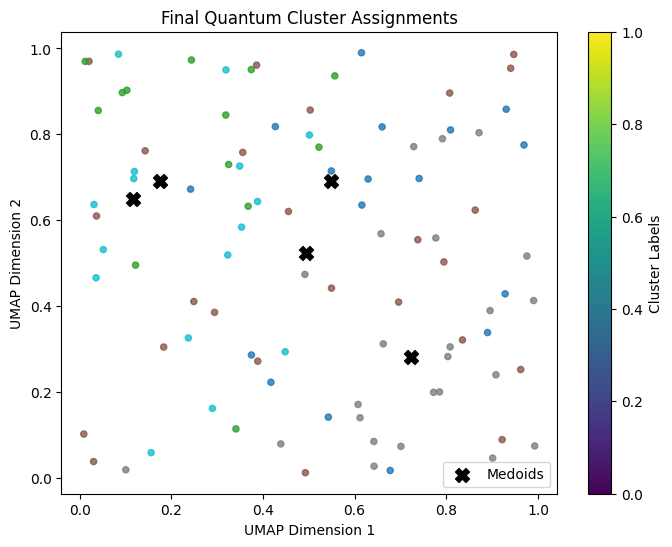

Cluster visualization saved at: c:\Users\karishma\OneDrive\Projects\qCLEF\data\test_data\final_test_quantum_clusters_plot.png


In [17]:
unique_labels = np.unique(all_cluster_labels)
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
normalized_labels = np.array([label_mapping[label] for label in all_cluster_labels])

plt.figure(figsize=(8, 6))
plt.scatter(doc_embeddings[:, 0], doc_embeddings[:, 1], c=normalized_labels, cmap='tab10', s=20, alpha=0.8)
plt.scatter(medoid_embeddings[:, 0], medoid_embeddings[:, 1], c='black', marker="X", s=100, label="Medoids")
plt.colorbar(label="Cluster Labels")
plt.title("Final Quantum Cluster Assignments")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

plot_path = os.path.join(data_dir, "final_test_quantum_clusters_plot.png")
plt.savefig(plot_path, dpi=300)
plt.legend()
plt.show()

print(f"Cluster visualization saved at: {plot_path}")